In [30]:
import json
import numpy as np
import pandas as pd
import re
from pymongo import MongoClient

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [2]:
# getting date from MongoDB
client = MongoClient('localhost', 27017)
db = client['DDR-ML-Final']
col_main = db['article_main_content']
col_meta = db['article_metadata']
col_delegates = db['delegates']
col_funding = db['fec Filings']

In [3]:
# creating dataframes for all the data
article_content = pd.DataFrame(list(col_main.find()))

article_meta = pd.DataFrame(list(col_meta.find()))

delegates = pd.DataFrame(list(col_delegates.find()))

funding = pd.DataFrame(list(col_funding.find()))

In [198]:
article_meta['headline'][0]

{'main': 'Fact-Checking Bernie Sanders Before the Iowa Caucuses',
 'kicker': 'Fact Check',
 'content_kicker': None,
 'print_headline': 'Sanders on Opposing War, Crossing the Aisle and Medicare for All',
 'name': None,
 'seo': None,
 'sub': None}

In [19]:
# in this code, we will look at the headlines of the news article
headlines = [article_meta['headline'][i]['print_headline'] for i in range(len(article_meta))]
# filter out None
headlines_flted = [i for i in headlines if i] 

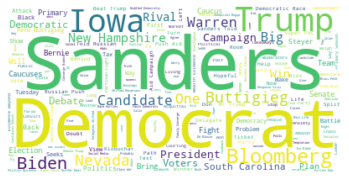

In [29]:
# Look at the most frequent words from NYT's headlines from Feb-Super Tuesday
text = " ".join(hdline for hdline in headlines_flted)

stopwords = set(STOPWORDS)

# Generate a word cloud image and display
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

By looking at the words frequency from the news titles, we can already see that Bernie Sanders and Democrat are the most mentioned words, while Biden is mentioned a lot less. 

### Topic Modeling using LDA

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

In [48]:
no_topics = 6 #@param {type:"integer"}

no_top_words = 5 #@param {type:"integer"}

no_top_documents = 3 #@param {type:"integer"}

In [49]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print(documents[doc_index])

In [50]:
#@title Run LDA

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(headlines_flted)
tf_feature_names = tf_vectorizer.get_feature_names()

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

print("LDA Topics")
display_topics(lda_H, lda_W, tf_feature_names, headlines_flted, no_top_words, no_top_documents)


LDA Topics
Topic 0:
new democratic nevada hampshire sanders
As Primary Season Begins, YouTube Says It Will Ban Misleading Content
As Primary Season Begins, YouTube Says It Will Ban Misleading Content
Courting the Latino Vote, A Strong Nevada Bloc, As the Caucuses Loom
Topic 1:
sanders biden rivals push stop
Meaningful Discussion of Abortion by Rivals Shows This Election Cycle Is Different
Meaningful Discussion of Abortion by Rivals Shows This Election Cycle Is Different
Meaningful Discussion of Abortion by Rivals Shows This Election Cycle Is Different
Topic 2:
bloomberg campaign told aid suddenly
Democratic Hopefuls Make Final Appeals in a Blurred Caucus Race
Democratic Hopefuls Make Final Appeals in a Blurred Caucus Race
McConnell’s Moment: A Master Strategist Secures a Swift Acquittal
Topic 3:
trump democrats big candidates virus
Split Senate Clears Trump on Each Count in Finale of a Bitter Impeachment Battle
Split Senate Clears Trump on Each Count in Finale of a Bitter Impeachment B

### LSA VS LDA

Reference: https://www.kaggle.com/rcushen/topic-modelling-with-lsa-and-lda

In [160]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [200]:
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

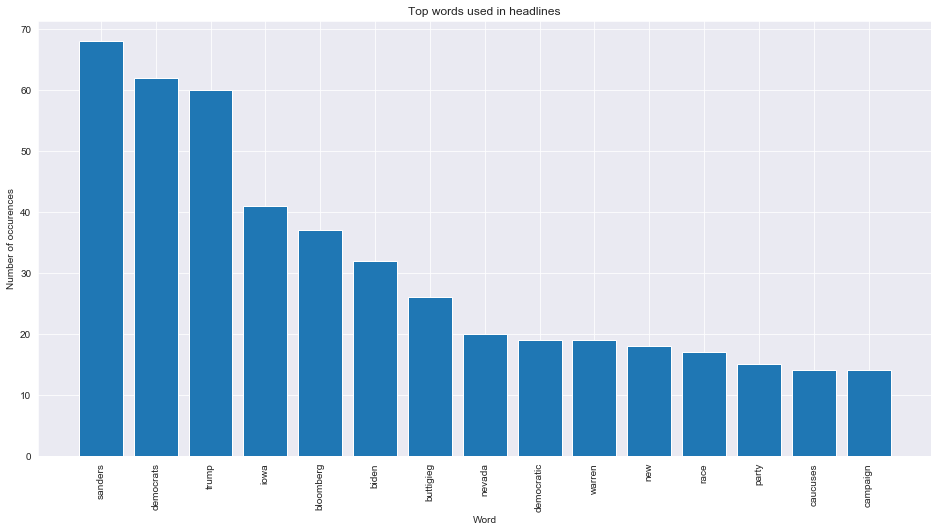

In [202]:
headline_data = pd.Series(headlines_flted)
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=headline_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words used in headlines');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [234]:
# data preprocessing for topic modeling
count_vectorizer = CountVectorizer(stop_words='english', max_features=1000)
text_sample = headline_data.sample(n=513, random_state=0).values
document_term_matrix = count_vectorizer.fit_transform(text_sample)

print('Headline after vectorization: \n{}'.format(document_term_matrix[123]))

Headline after vectorization: 
  (0, 612)	1
  (0, 95)	1
  (0, 419)	1
  (0, 385)	1
  (0, 482)	1
  (0, 516)	1


#### LSA

In [235]:
# define number of topics to see
n_topics = 8

# train the LSA model
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [236]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topics for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

In [237]:
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of topics described with n most common words after classification.
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [238]:
# get clusterd topics along with keys
lsa_keys = get_keys(lsa_topic_matrix)

# get the topics described with 10 words
top_10_words_lsa = get_top_n_words(10, lsa_keys, document_term_matrix, count_vectorizer)

# print out 8 topics from the LSA model
for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  sanders democrats bernie campaign iowa delegates recanvass push buttigieg war
Topic 2:  trump party bloomberg 2020 virus election russian don response calls
Topic 3:  democrats iowa ticket voting fiasco early mind nevada hive angst
Topic 4:  iowa biden big fight caucus long isn fault evidence plans
Topic 5:  bloomberg candidates warren tax amazon suddenly temptation potential spring polls
Topic 6:  democratic new hampshire race primary debate politics steyer business family
Topic 7:  south carolina super biden vote president life tuesday democrats far
Topic 8:  buttigieg caucuses nevada vote pete come president voters courting bloc


In [239]:
# using t-SNE technique to properly compare clusters with two-dimensional representations
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 513 samples in 0.000s...
[t-SNE] Computed neighbors for 513 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 513 / 513
[t-SNE] Mean sigma: 0.039070
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.279877
[t-SNE] KL divergence after 2000 iterations: 0.196058


In [240]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [241]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [243]:
# using only 3 word to describe the same 8 clustered topics and plot them with corresponding centroids.
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

#### LDA

In [244]:
# LDA modeling
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(document_term_matrix)

In [245]:
# get clusterd topics along with keys
lda_keys = get_keys(lda_topic_matrix)

# get the topics described with 10 words
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

# print out each topic and see the summary words
for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  trump rivals team russian calls voters rule candidates new buttigieg
Topic 2:  biden democrats south carolina bloomberg candidates iowa trump warren sanders
Topic 3:  trump democrats caucuses nevada big president life vote party debate
Topic 4:  yang democrats bid rogue moderators president manchin adds long outlasted
Topic 5:  democratic race bernie steyer appeals spending trump new hampshire campaign
Topic 6:  campaign sanders aid don told view russian push media people
Topic 7:  buttigieg bloomberg biden pete isn senate split bruni fault care
Topic 8:  sanders iowa democrats warren fight new recanvass delegates buttigieg hampshire


In [246]:
# using t-SNE technique to properly compare clusters with two-dimensional representations
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 513 samples in 0.000s...
[t-SNE] Computed neighbors for 513 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 513 / 513
[t-SNE] Mean sigma: 0.058677
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.471237
[t-SNE] KL divergence after 2000 iterations: 0.039031


In [247]:
# using only 3 word to describe the same 8 clustered topics and plot them with corresponding centroids.
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)